Проверка датасета, размеченного моделью на валидность

In [74]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_selection import mutual_info_regression



In [63]:
moex_index = pd.read_parquet('../data/moex_index.parquet')
moex_index

,open,close,high,low,value,volume,begin,end,company
0,2157.18,2169.64,2169.64,2157.18,3.799025e+09,0,2023-01-03 10:00:00,2023-01-03 10:59:59,IMOEX
1,2169.70,2171.85,2174.23,2169.66,2.168052e+09,0,2023-01-03 11:00:00,2023-01-03 11:59:59,IMOEX
2,2171.83,2168.96,2171.89,2168.22,1.341424e+09,0,2023-01-03 12:00:00,2023-01-03 12:59:59,IMOEX
3,2168.94,2169.22,2170.89,2168.26,9.352780e+08,0,2023-01-03 13:00:00,2023-01-03 13:59:59,IMOEX
4,2169.17,2169.14,2170.14,2167.67,9.711201e+08,0,2023-01-03 14:00:00,2023-01-03 14:59:59,IMOEX
...,...,...,...,...,...,...,...,...,...
5157,3109.57,3113.54,3116.77,3107.33,3.869001e+09,0,2025-03-27 13:00:00,2025-03-27 13:59:59,IMOEX
5158,3113.73,3113.24,3124.32,3112.85,6.052590e+09,0,2025-03-27 14:00:00,2025-03-27 14:59:59,IMOEX
5159,3113.11,3084.11,3114.79,3083.64,1.124272e+10,0,2025-03-27 15:00:00,2025-03-27 15:59:59,IMOEX
5160,3084.13,3087.25,3093.76,3076.15,1.108031e+10,0,2025-03-27 16:00:00,2025-03-27 16:59:59,IMOEX


In [64]:
model_dataset = pd.read_json('../data/model_data/model_data_cache.json')
model_dataset = model_dataset[model_dataset['reasoning'] != '']
model_dataset

,reasoning,answer,article_text,sphere,source,date
0,"Статья о финансовых результатах Rivian, америк...",15.0,Москва. 21 февраля. INTERFAX.RU - Американски...,Финансы,Интерфакс,2025-02-21
1,"Статья рассказывает о социальной акции ПАО ""Га...",0.0,Москва. 21 февраля. INTERFAX.RU - Село Майма ...,Финансы,Интерфакс,2025-02-21
2,"Статья сообщает о значительном убытке ПАО ""Рас...",-75.0,"Москва. 21 февраля. INTERFAX.RU - ПАО ""Распад...",Финансы,Интерфакс,2025-02-21
4,"Статья фокусируется на динамике рубля и юаня, ...",25.0,"Москва. 21 февраля. INTERFAX.RU - На ""Московс...",Энергетика,Интерфакс,2025-02-21
5,Статья описывает судебное решение о взыскании ...,25.0,Москва. 21 февраля. INTERFAX.RU - Арбитражный...,Финансы,Интерфакс,2025-02-21
...,...,...,...,...,...,...
10708,Введение налогов на криптовалюты и регулирован...,-20.0,**Турция планирует ввести налоги на криптоакти...,Финансы/Энергетика,The Экономист,2024-05-12
10709,"Статья о проблемах в сельском хозяйстве, вызва...",25.0,**Российские фермеры и сельхозкомпании на гран...,Энергетика,The Экономист,2024-05-11
10710,Статья рассказывает о финансовой связи Романа ...,10.0,**Абрамович все еще влияет на футбол в условия...,Финансы,The Экономист,2024-05-11
10711,Статья описывает случай мошенничества с исполь...,-30.0,**Более 26 миллионов рублей пропало со счетов ...,Финансы,The Экономист,2024-05-10


Агрегируем данные по дням

In [65]:
moex_index['date'] = pd.to_datetime(moex_index['begin']).dt.date

moex_daily = moex_index.groupby('date')['close'].last().reset_index()
moex_daily['moex_change'] = moex_daily['close'].pct_change() * 100  # изменение в процентах


Подготовка ответов

In [66]:

model_dataset['date'] = pd.to_datetime(model_dataset['date']).dt.date

answers_daily = model_dataset.groupby('date')['answer'].sum().reset_index()
answers_daily['answer_change'] = answers_daily['answer'].diff()  # изменение в абсолютных значениях


In [67]:

merged_data = pd.merge(moex_daily, answers_daily, on='date', how='inner')

merged_data = merged_data.dropna()


In [68]:
merged_data

,date,close,moex_change,answer,answer_change
1,2023-01-04,2168.42,-0.196071,-125.0,-195.0
2,2023-01-05,2156.67,-0.541869,35.0,160.0
3,2023-01-06,2156.39,-0.012983,-15.0,-50.0
4,2023-01-09,2163.50,0.329718,-50.0,-200.0
5,2023-01-10,2159.51,-0.184423,-110.0,-60.0
...,...,...,...,...,...
540,2025-02-17,3308.41,3.874725,1132.0,1092.0
541,2025-02-18,3258.76,-1.500721,1467.0,335.0
542,2025-02-19,3270.64,0.364556,609.0,-858.0
543,2025-02-20,3292.62,0.672040,1674.0,1065.0


Расчитаем корреляцию

In [69]:
pearson_corr = merged_data['moex_change'].corr(merged_data['answer'])

# Корреляция Спирмена 
spearman_corr = merged_data['moex_change'].corr(merged_data['answer'], method='spearman')

from scipy import stats
r, p_value = stats.pearsonr(merged_data['moex_change'], merged_data['answer'])

print(f"Корреляция Пирсона: {pearson_corr:.4f}")
print(f"P-значение: {p_value:.4f}")

Корреляция Пирсона: 0.1536
P-значение: 0.0003


Визуализация

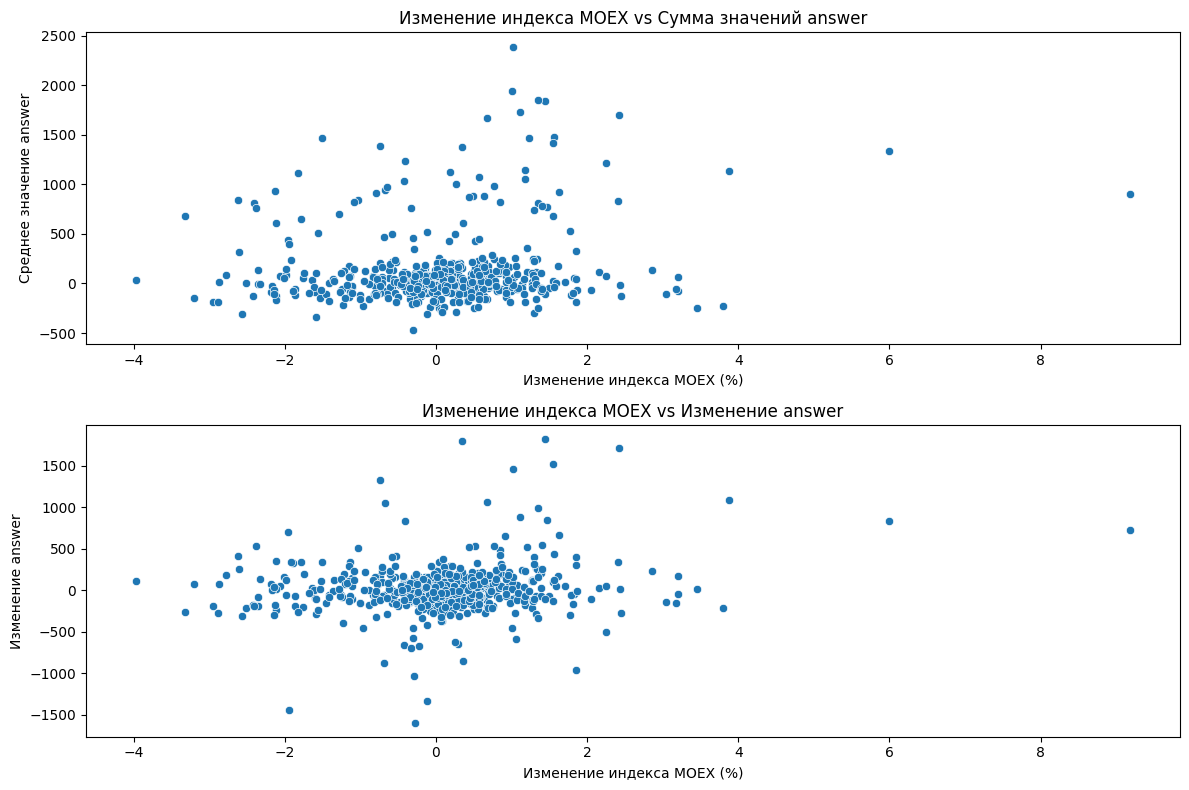

In [70]:



plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
sns.scatterplot(x='moex_change', y='answer', data=merged_data)
plt.title('Изменение индекса MOEX vs Сумма значений answer')
plt.xlabel('Изменение индекса MOEX (%)')
plt.ylabel('Среднее значение answer')

plt.subplot(2, 1, 2)
sns.scatterplot(x='moex_change', y='answer_change', data=merged_data)
plt.title('Изменение индекса MOEX vs Изменение answer')
plt.xlabel('Изменение индекса MOEX (%)')
plt.ylabel('Изменение answer')

plt.tight_layout()
plt.show()


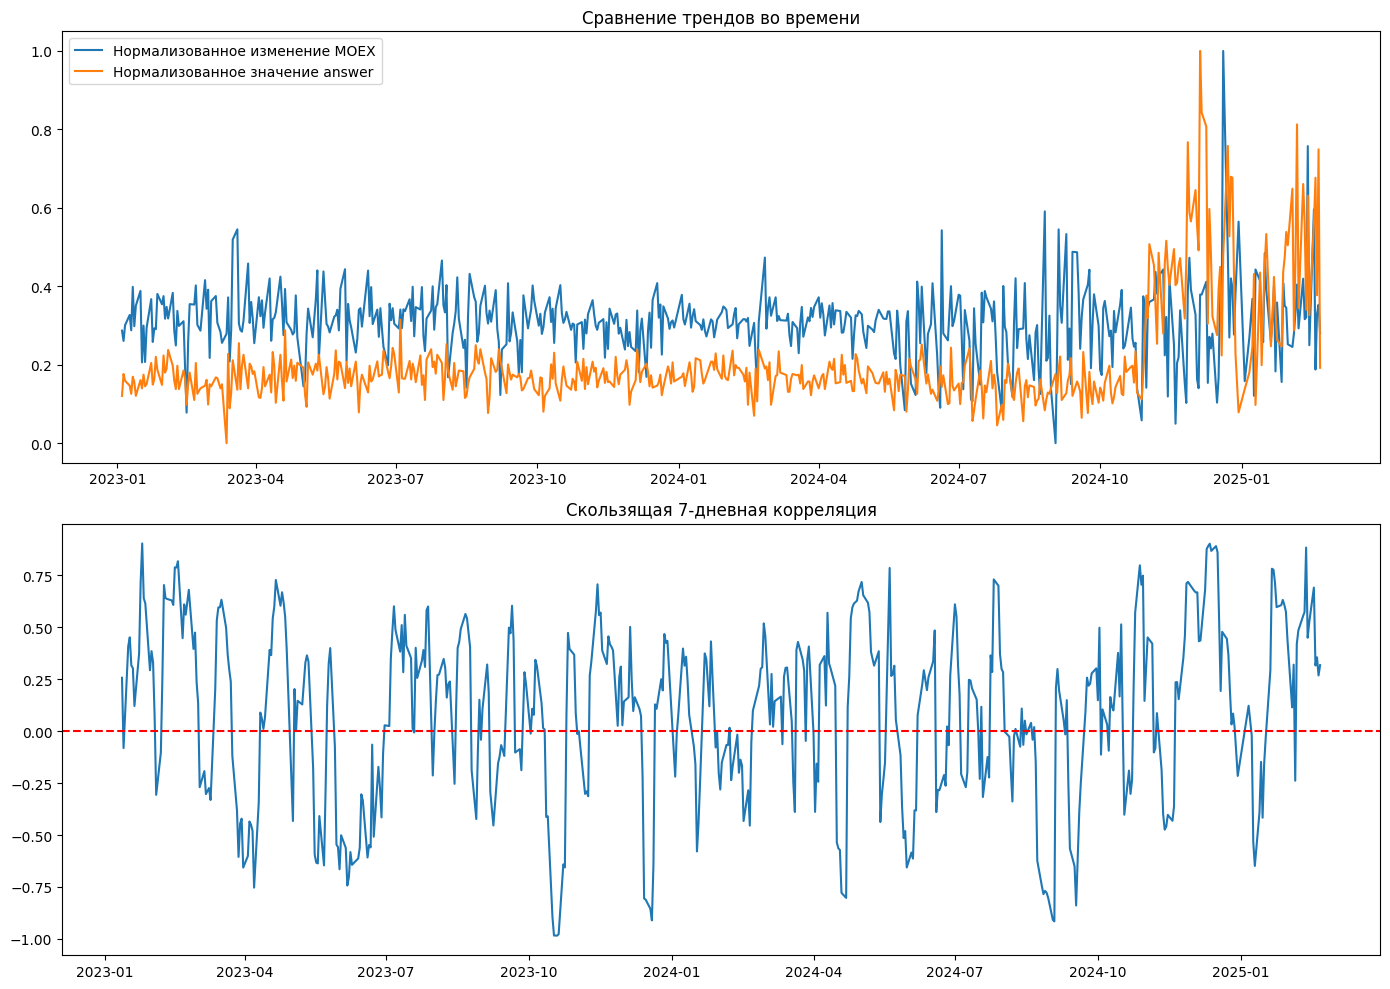

In [71]:
plt.figure(figsize=(14, 10))

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

plot_data = merged_data.copy()
plot_data[['norm_moex_change', 'norm_answer']] = scaler.fit_transform(
    plot_data[['moex_change', 'answer']])

plt.subplot(2, 1, 1)
plt.plot(plot_data['date'], plot_data['norm_moex_change'], label='Нормализованное изменение MOEX')
plt.plot(plot_data['date'], plot_data['norm_answer'], label='Нормализованное значение answer')
plt.title('Сравнение трендов во времени')
plt.legend()

window = 7 
plot_data['rolling_corr'] = plot_data['moex_change'].rolling(window).corr(plot_data['answer'])

plt.subplot(2, 1, 2)
plt.plot(plot_data['date'], plot_data['rolling_corr'])
plt.title(f'Скользящая {window}-дневная корреляция')
plt.axhline(y=0, color='r', linestyle='--')

plt.tight_layout()
plt.show()

Посмотрим энтропию

In [82]:


X = merged_data['moex_change'].values.reshape(-1, 1)
y = merged_data['answer'].values

mi = mutual_info_regression(X, y)[0]
print(f"Взаимная информация: {mi:.4f}")

def entropy(x, bins=10):
    hist, _ = np.histogram(x, bins=bins)
    p = hist / float(len(x))
    p = p[p > 0]
    return -np.sum(p * np.log2(p))

def conditional_entropy(x, y, bins=4):
    y_bins = np.linspace(min(y), max(y), bins+1)
    y_indices = np.digitize(y, y_bins)
    
    ce = 0
    for i in range(1, bins+1):
        x_i = x[y_indices == i]
        if len(x_i) > 0:
            ce += (len(x_i) / len(x)) * entropy(x_i, bins)
    
    return ce

h_moex = entropy(merged_data['moex_change'])
h_answer = entropy(merged_data['answer'])
h_moex_given_answer = conditional_entropy(merged_data['moex_change'], merged_data['answer'])
h_answer_given_moex = conditional_entropy(merged_data['answer'], merged_data['moex_change'])

print(f"Энтропия MOEX: {h_moex:.4f}")
print(f"Энтропия answer: {h_answer:.4f}")
print(f"Условная энтропия MOEX|answer: {h_moex_given_answer:.4f}")
print(f"Условная энтропия answer|MOEX: {h_answer_given_moex:.4f}")
print(f"Снижение неопределенности MOEX при знании answer: {(h_moex - h_moex_given_answer) / h_moex * 100:.2f}%")
print(f"Снижение неопределенности answer при знании MOEX: {(h_answer - h_answer_given_moex) / h_answer * 100:.2f}%")

Взаимная информация: 0.0616
Энтропия MOEX: 1.8439
Энтропия answer: 1.7130
Условная энтропия MOEX|answer: 1.3110
Условная энтропия answer|MOEX: 0.7978
Снижение неопределенности MOEX при знании answer: 28.90%
Снижение неопределенности answer при знании MOEX: 53.43%


Отсюда следует, что несмотря на слабую связь, знание одной из переменных СУЩЕСТВЕННО снижает неопределенность другой

Выполним схожий анализ в контексте цен акций по сферам
Для примера возьмем сбер и газпром

In [106]:
moex_data = pd.read_parquet('../data/moex.parquet')
moex_data = pd.concat([moex_data[moex_data['company'] == 'SBER'], moex_data[moex_data['company'] == 'GAZP']])
moex_data

,company,open,close,begin,end
0,SBER,141.60,141.60,2023-01-03 09:00:00,2023-01-03 09:59:59
1,SBER,141.60,142.66,2023-01-03 10:00:00,2023-01-03 10:59:59
2,SBER,142.66,142.42,2023-01-03 11:00:00,2023-01-03 11:59:59
3,SBER,142.43,141.91,2023-01-03 12:00:00,2023-01-03 12:59:59
4,SBER,141.91,141.67,2023-01-03 13:00:00,2023-01-03 13:59:59
...,...,...,...,...,...
16623,GAZP,165.11,165.94,2025-02-28 16:00:00,2025-02-28 16:59:59
16624,GAZP,165.94,167.12,2025-02-28 17:00:00,2025-02-28 17:59:59
16625,GAZP,167.11,167.70,2025-02-28 18:00:00,2025-02-28 18:59:59
16626,GAZP,167.72,169.86,2025-02-28 19:00:00,2025-02-28 19:59:59


Подготовим данные для анализа:

In [107]:
moex_data['date'] = pd.to_datetime(moex_data['begin']).dt.date

sber_data = moex_data[moex_data['company'] == 'SBER']
gazp_data = moex_data[moex_data['company'] == 'GAZP']

sber_daily = sber_data.groupby('date')['close'].last().reset_index()
sber_daily['sber_change'] = sber_daily['close'].pct_change() * 100  # изменение в процентах

gazp_daily = gazp_data.groupby('date')['close'].last().reset_index()
gazp_daily['gazp_change'] = gazp_daily['close'].pct_change() * 100  # изменение в процентах




SBER корреляции:
Со всеми ответами: 0.1054 (p-value: 0.0139)
С финансовыми ответами: 0.1034 (p-value: 0.0159)
С энергетическими ответами: 0.0845 (p-value: 0.0488)

GAZP корреляции:
Со всеми ответами: 0.1109 (p-value: 0.0096)
С финансовыми ответами: 0.0855 (p-value: 0.0461)
С энергетическими ответами: 0.1219 (p-value: 0.0044)

Корреляции по источникам:
SBER - Интерфакс (все): 0.0975 (p-value: 0.0230)
SBER - Интерфакс (финансы): 0.0880 (p-value: 0.0402)
SBER - Интерфакс (энергетика): 0.0904 (p-value: 0.0351)
GAZP - Интерфакс (все): 0.1317 (p-value: 0.0021)
GAZP - Интерфакс (финансы): 0.1114 (p-value: 0.0093)
GAZP - Интерфакс (энергетика): 0.1357 (p-value: 0.0015)
SBER - Копейка рубль бережёт (все): 0.0345 (p-value: 0.4221)
SBER - Копейка рубль бережёт (финансы): 0.0492 (p-value: 0.2515)
SBER - Копейка рубль бережёт (энергетика): -0.0078 (p-value: 0.8559)
GAZP - Копейка рубль бережёт (все): -0.0329 (p-value: 0.4441)
GAZP - Копейка рубль бережёт (финансы): -0.0211 (p-value: 0.6234)
GAZP - 

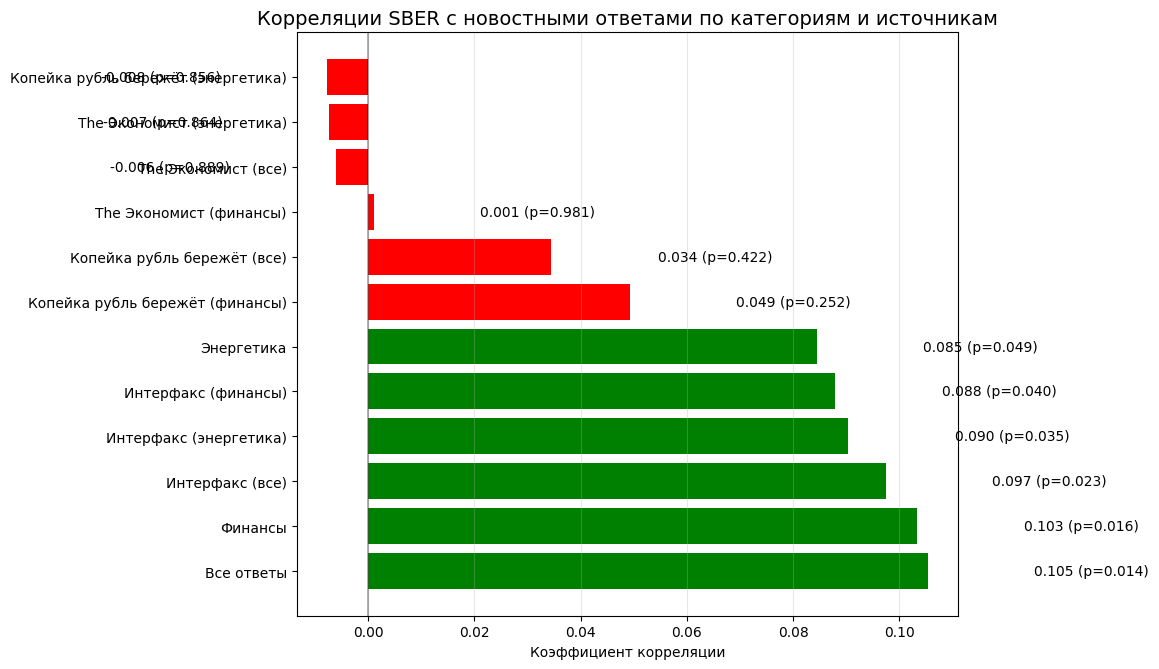

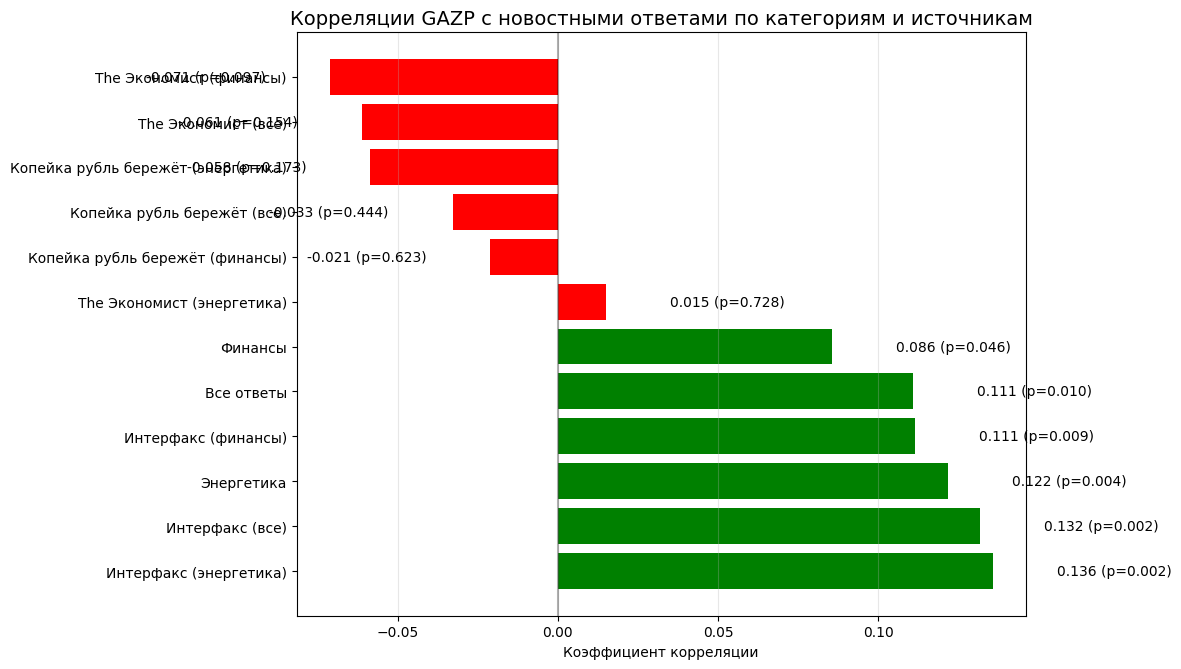

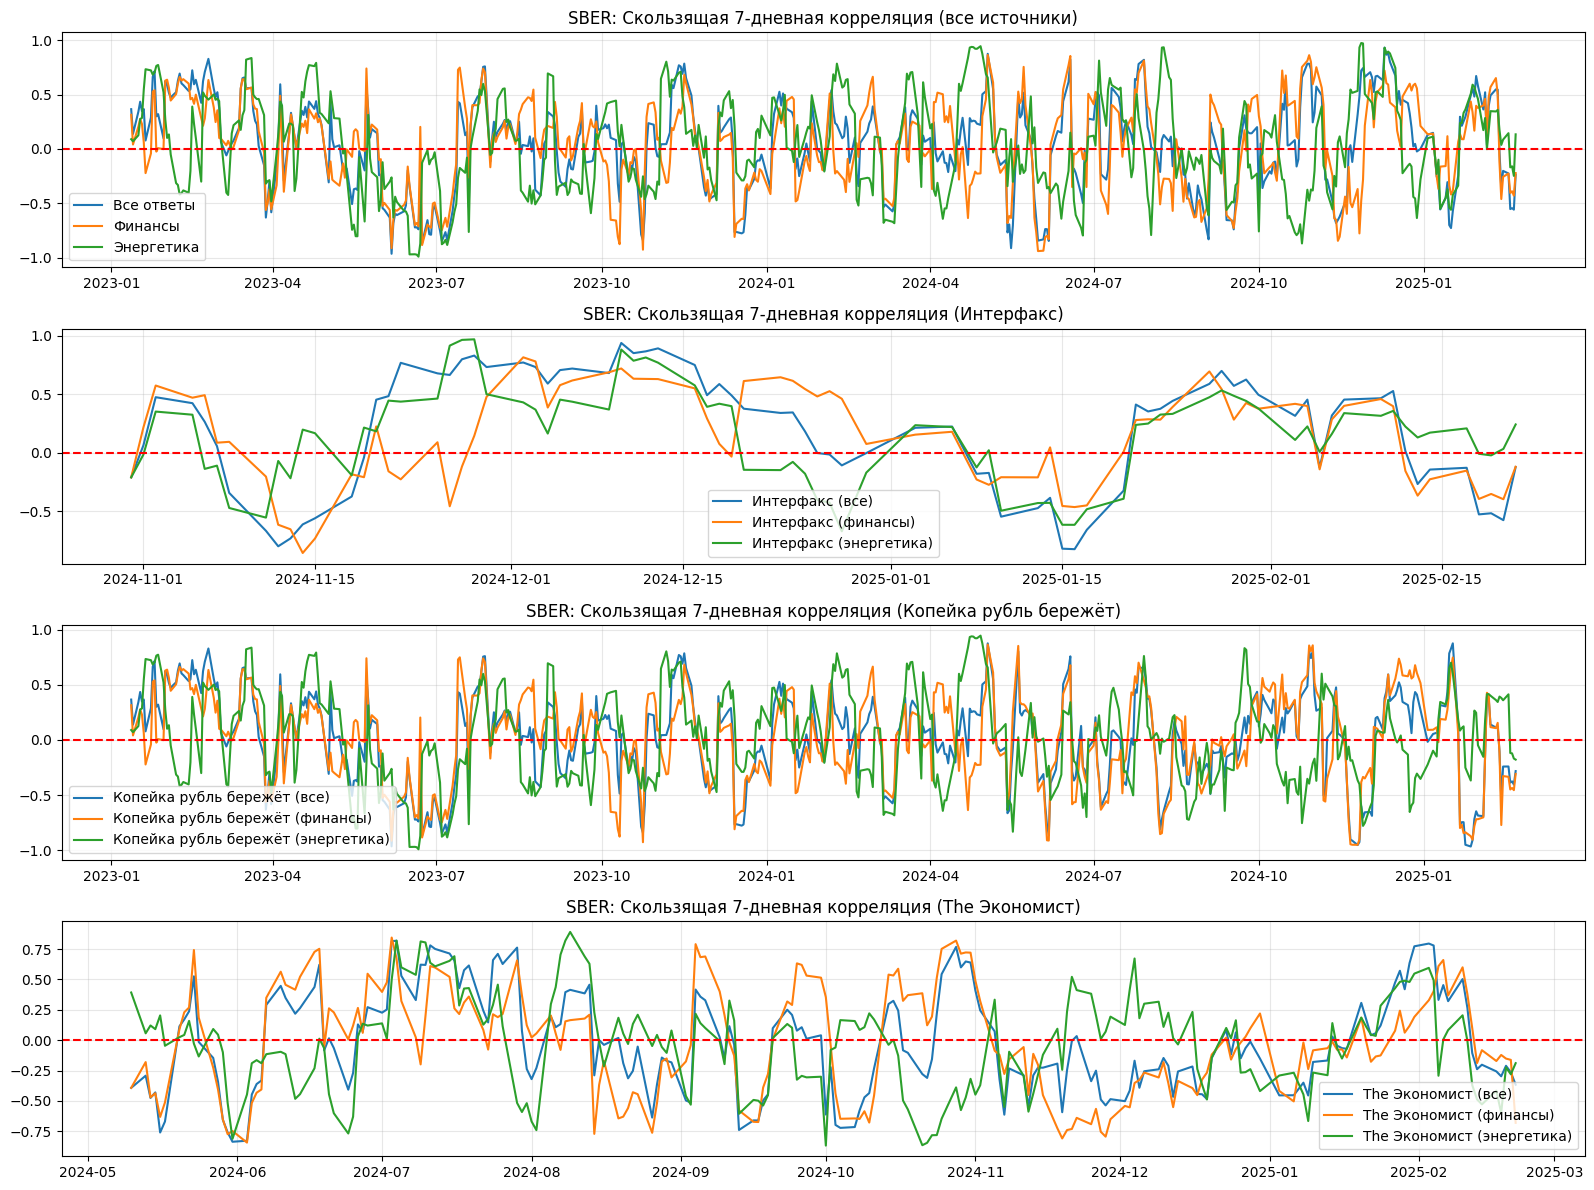

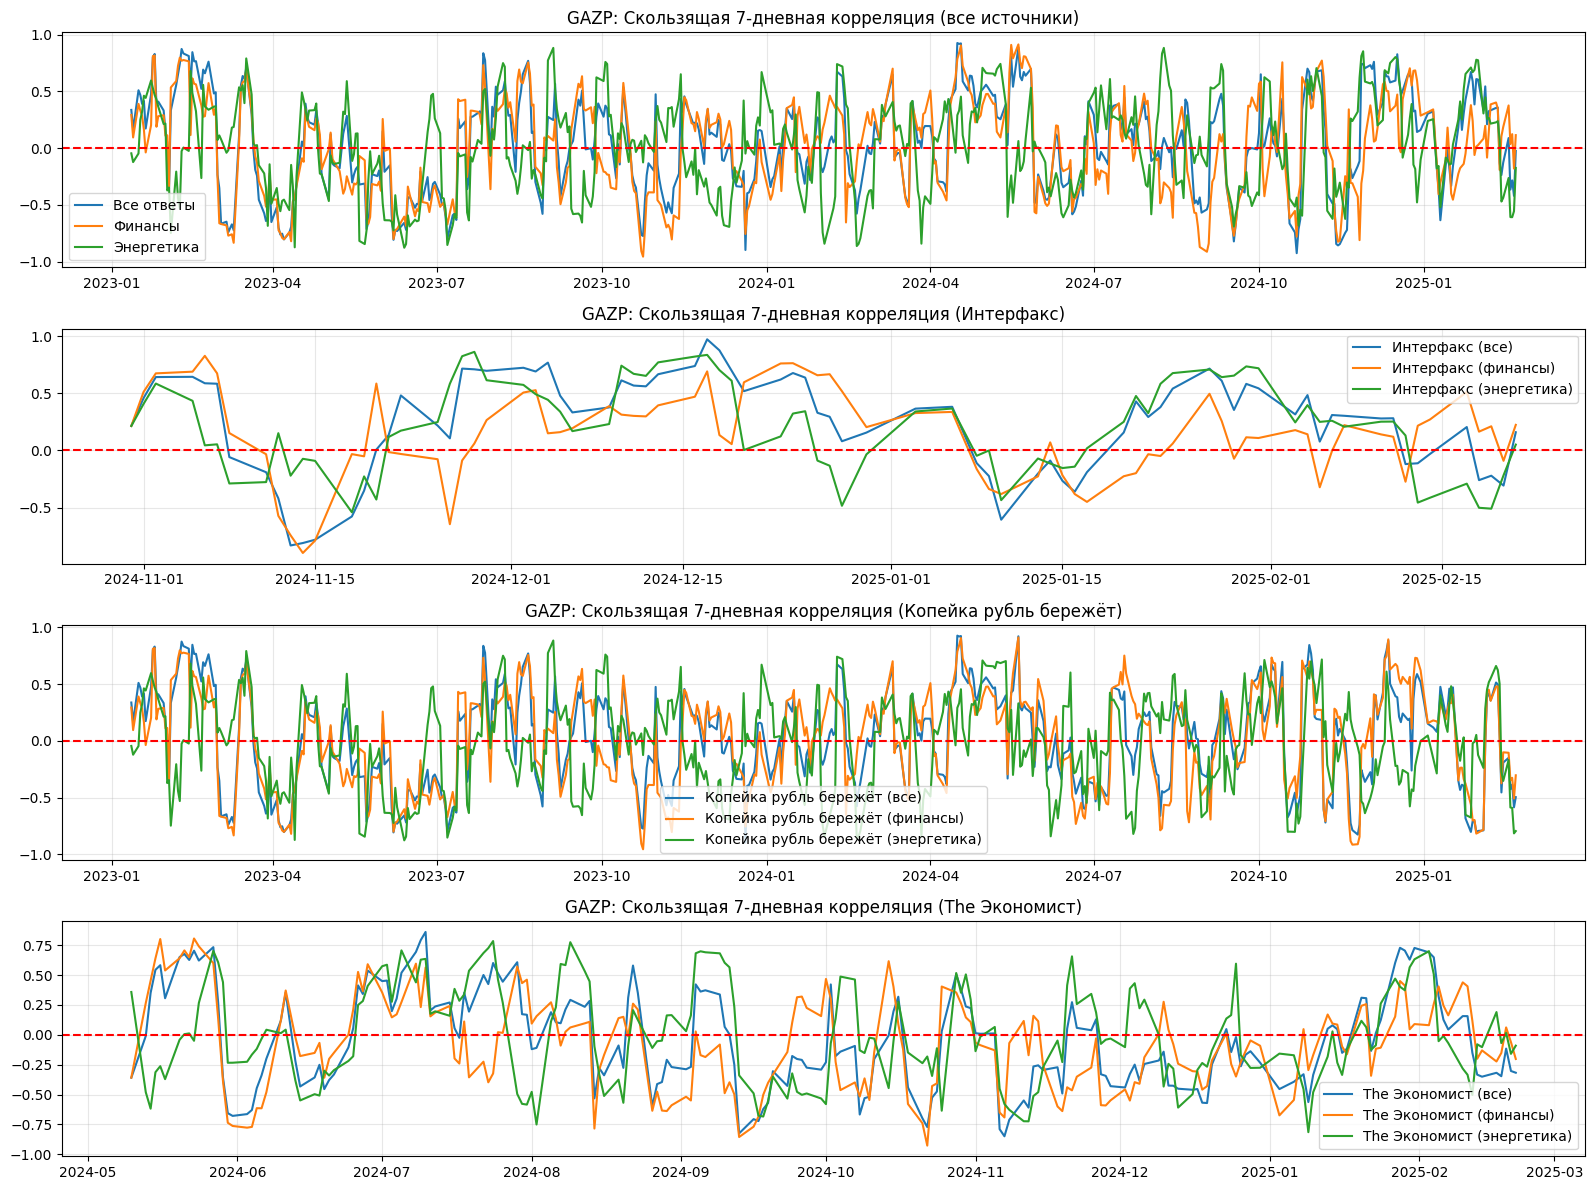

TypeError: Image data of dtype object cannot be converted to float

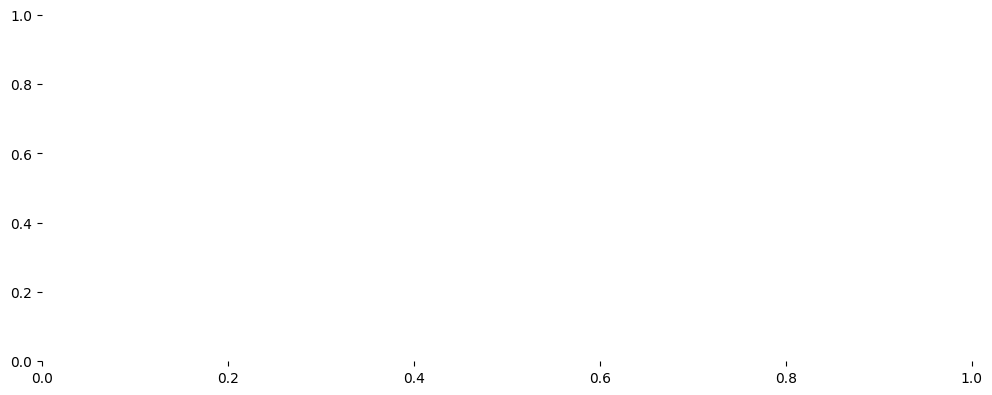

In [108]:
if 'sphere' in model_dataset.columns and 'source' in model_dataset.columns:
    model_data_processed = model_dataset.copy()
    
    model_data_processed['contains_finance'] = model_data_processed['sphere'].str.contains('Финансы', case=False, na=False)
    model_data_processed['contains_energy'] = model_data_processed['sphere'].str.contains('Энергетика', case=False, na=False)
    
    sources = model_data_processed['source'].unique()
    
    answers_daily = model_dataset.groupby('date')['answer'].sum().reset_index()
    answers_daily['answer_change'] = answers_daily['answer'].diff()
    
    finance_daily = model_data_processed[model_data_processed['contains_finance']].groupby('date')['answer'].sum().reset_index()
    finance_daily.rename(columns={'answer': 'finance_answer'}, inplace=True)
    finance_daily['finance_answer_change'] = finance_daily['finance_answer'].diff()
    
    energy_daily = model_data_processed[model_data_processed['contains_energy']].groupby('date')['answer'].sum().reset_index()
    energy_daily.rename(columns={'answer': 'energy_answer'}, inplace=True)
    energy_daily['energy_answer_change'] = energy_daily['energy_answer'].diff()
    
    answers_daily = pd.merge(answers_daily, finance_daily, on='date', how='left')
    answers_daily = pd.merge(answers_daily, energy_daily, on='date', how='left')
    
    for source in sources:
        # Все ответы по источнику
        source_daily = model_data_processed[model_data_processed['source'] == source].groupby('date')['answer'].sum().reset_index()
        source_daily.rename(columns={'answer': f'{source}_answer'}, inplace=True)
        source_daily[f'{source}_answer_change'] = source_daily[f'{source}_answer'].diff()
        
        # Финансовые ответы по источнику
        source_finance_daily = model_data_processed[
            (model_data_processed['source'] == source) & 
            (model_data_processed['contains_finance'])
        ].groupby('date')['answer'].sum().reset_index()
        source_finance_daily.rename(columns={'answer': f'{source}_finance_answer'}, inplace=True)
        
        # Энергетические ответы по источнику
        source_energy_daily = model_data_processed[
            (model_data_processed['source'] == source) & 
            (model_data_processed['contains_energy'])
        ].groupby('date')['answer'].sum().reset_index()
        source_energy_daily.rename(columns={'answer': f'{source}_energy_answer'}, inplace=True)
        
        # Объединяем агрегации по источнику
        answers_daily = pd.merge(answers_daily, source_daily, on='date', how='left')
        answers_daily = pd.merge(answers_daily, source_finance_daily, on='date', how='left')
        answers_daily = pd.merge(answers_daily, source_energy_daily, on='date', how='left')
    
    # Заполняем отсутствующие значения нулями
    answers_daily.fillna(0, inplace=True)

# Объединяем данные SBER и ответы
merged_sber = pd.merge(sber_daily, answers_daily, on='date', how='inner')
merged_sber = merged_sber.dropna()

# Объединяем данные GAZP и ответы
merged_gazp = pd.merge(gazp_daily, answers_daily, on='date', how='inner')
merged_gazp = merged_gazp.dropna()

# Функция для расчета корреляции и p-value
from scipy import stats

def corr_with_pvalue(x, y):
    corr, p_value = stats.pearsonr(x, y)
    return corr, p_value

correlation_results = []

print("SBER корреляции:")
corr_all, p_all = corr_with_pvalue(merged_sber['sber_change'], merged_sber['answer'])
corr_fin, p_fin = corr_with_pvalue(merged_sber['sber_change'], merged_sber['finance_answer'])
corr_eng, p_eng = corr_with_pvalue(merged_sber['sber_change'], merged_sber['energy_answer'])

print(f"Со всеми ответами: {corr_all:.4f} (p-value: {p_all:.4f})")
print(f"С финансовыми ответами: {corr_fin:.4f} (p-value: {p_fin:.4f})")
print(f"С энергетическими ответами: {corr_eng:.4f} (p-value: {p_eng:.4f})")

correlation_results.append({'Stock': 'SBER', 'Category': 'Все ответы', 'Correlation': corr_all, 'P-value': p_all})
correlation_results.append({'Stock': 'SBER', 'Category': 'Финансы', 'Correlation': corr_fin, 'P-value': p_fin})
correlation_results.append({'Stock': 'SBER', 'Category': 'Энергетика', 'Correlation': corr_eng, 'P-value': p_eng})

print("\nGAZP корреляции:")
corr_all_g, p_all_g = corr_with_pvalue(merged_gazp['gazp_change'], merged_gazp['answer'])
corr_fin_g, p_fin_g = corr_with_pvalue(merged_gazp['gazp_change'], merged_gazp['finance_answer'])
corr_eng_g, p_eng_g = corr_with_pvalue(merged_gazp['gazp_change'], merged_gazp['energy_answer'])

print(f"Со всеми ответами: {corr_all_g:.4f} (p-value: {p_all_g:.4f})")
print(f"С финансовыми ответами: {corr_fin_g:.4f} (p-value: {p_fin_g:.4f})")
print(f"С энергетическими ответами: {corr_eng_g:.4f} (p-value: {p_eng_g:.4f})")

correlation_results.append({'Stock': 'GAZP', 'Category': 'Все ответы', 'Correlation': corr_all_g, 'P-value': p_all_g})
correlation_results.append({'Stock': 'GAZP', 'Category': 'Финансы', 'Correlation': corr_fin_g, 'P-value': p_fin_g})
correlation_results.append({'Stock': 'GAZP', 'Category': 'Энергетика', 'Correlation': corr_eng_g, 'P-value': p_eng_g})

if 'source' in model_dataset.columns:
    print("\nКорреляции по источникам:")
    
    for source in sources:
        if f'{source}_answer' in merged_sber.columns:
            corr_source, p_source = corr_with_pvalue(merged_sber['sber_change'], merged_sber[f'{source}_answer'])
            print(f"SBER - {source} (все): {corr_source:.4f} (p-value: {p_source:.4f})")
            correlation_results.append({'Stock': 'SBER', 'Category': f'{source} (все)', 'Correlation': corr_source, 'P-value': p_source})
            
            if f'{source}_finance_answer' in merged_sber.columns:
                corr_source_fin, p_source_fin = corr_with_pvalue(merged_sber['sber_change'], merged_sber[f'{source}_finance_answer'])
                print(f"SBER - {source} (финансы): {corr_source_fin:.4f} (p-value: {p_source_fin:.4f})")
                correlation_results.append({'Stock': 'SBER', 'Category': f'{source} (финансы)', 'Correlation': corr_source_fin, 'P-value': p_source_fin})
            
            if f'{source}_energy_answer' in merged_sber.columns:
                corr_source_eng, p_source_eng = corr_with_pvalue(merged_sber['sber_change'], merged_sber[f'{source}_energy_answer'])
                print(f"SBER - {source} (энергетика): {corr_source_eng:.4f} (p-value: {p_source_eng:.4f})")
                correlation_results.append({'Stock': 'SBER', 'Category': f'{source} (энергетика)', 'Correlation': corr_source_eng, 'P-value': p_source_eng})
            
            corr_source_g, p_source_g = corr_with_pvalue(merged_gazp['gazp_change'], merged_gazp[f'{source}_answer'])
            print(f"GAZP - {source} (все): {corr_source_g:.4f} (p-value: {p_source_g:.4f})")
            correlation_results.append({'Stock': 'GAZP', 'Category': f'{source} (все)', 'Correlation': corr_source_g, 'P-value': p_source_g})
            
            if f'{source}_finance_answer' in merged_gazp.columns:
                corr_source_fin_g, p_source_fin_g = corr_with_pvalue(merged_gazp['gazp_change'], merged_gazp[f'{source}_finance_answer'])
                print(f"GAZP - {source} (финансы): {corr_source_fin_g:.4f} (p-value: {p_source_fin_g:.4f})")
                correlation_results.append({'Stock': 'GAZP', 'Category': f'{source} (финансы)', 'Correlation': corr_source_fin_g, 'P-value': p_source_fin_g})
            
            if f'{source}_energy_answer' in merged_gazp.columns:
                corr_source_eng_g, p_source_eng_g = corr_with_pvalue(merged_gazp['gazp_change'], merged_gazp[f'{source}_energy_answer'])
                print(f"GAZP - {source} (энергетика): {corr_source_eng_g:.4f} (p-value: {p_source_eng_g:.4f})")
                correlation_results.append({'Stock': 'GAZP', 'Category': f'{source} (энергетика)', 'Correlation': corr_source_eng_g, 'P-value': p_source_eng_g})

results_df = pd.DataFrame(correlation_results)
results_df['Significant'] = results_df['P-value'] < 0.05

results_df['Abs_Correlation'] = np.abs(results_df['Correlation'])
results_df = results_df.sort_values(by=['Stock', 'Abs_Correlation'], ascending=[True, False])
results_df = results_df.drop(columns=['Abs_Correlation'])

print("\nСводная таблица результатов корреляций:")
print(results_df)

import matplotlib.pyplot as plt
import seaborn as sns

for stock in ['SBER', 'GAZP']:
    stock_results = results_df[results_df['Stock'] == stock].copy()
    
    stock_results = stock_results.sort_values(by='Correlation', ascending=False)
    
    plt.figure(figsize=(12, len(stock_results) * 0.4 + 2))
    
    colors = ['green' if sig else 'red' for sig in stock_results['Significant']]
    
    bars = plt.barh(stock_results['Category'], stock_results['Correlation'], color=colors)
    
    for i, bar in enumerate(bars):
        width = bar.get_width()
        p_value = stock_results.iloc[i]['P-value']
        label = f"{width:.3f} (p={p_value:.3f})"
        
        if width < 0:
            ha = 'right'
            x_pos = width - 0.02
        else:
            ha = 'left'
            x_pos = width + 0.02
            
        plt.text(x_pos, i, label, va='center', ha=ha)
    
    plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
    plt.title(f'Корреляции {stock} с новостными ответами по категориям и источникам', fontsize=14)
    plt.xlabel('Коэффициент корреляции')
    plt.tight_layout()
    plt.grid(axis='x', alpha=0.3)
    plt.savefig(f'{stock}_correlations_all_categories.png', dpi=300, bbox_inches='tight')
    plt.show()

# Визуализация скользящих корреляций по источникам
if 'source' in model_dataset.columns:
    # Для SBER
    plt.figure(figsize=(16, 12))
    
    # Подготовка данных для SBER
    scaler_sber = MinMaxScaler()
    plot_data_sber = merged_sber.copy()
    
    window = 7 
    
    plt.subplot(len(sources) + 1, 1, 1)
    plot_data_sber['rolling_corr_all'] = plot_data_sber['sber_change'].rolling(window).corr(plot_data_sber['answer'])
    plot_data_sber['rolling_corr_finance'] = plot_data_sber['sber_change'].rolling(window).corr(plot_data_sber['finance_answer'])
    plot_data_sber['rolling_corr_energy'] = plot_data_sber['sber_change'].rolling(window).corr(plot_data_sber['energy_answer'])
    
    plt.plot(plot_data_sber['date'], plot_data_sber['rolling_corr_all'], label='Все ответы')
    plt.plot(plot_data_sber['date'], plot_data_sber['rolling_corr_finance'], label='Финансы')
    plt.plot(plot_data_sber['date'], plot_data_sber['rolling_corr_energy'], label='Энергетика')
    plt.title(f'SBER: Скользящая {window}-дневная корреляция (все источники)', fontsize=12)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.legend(loc='best')
    plt.grid(True, alpha=0.3)
    
    for i, source in enumerate(sources, 1):
        if f'{source}_answer' in plot_data_sber.columns:
            plt.subplot(len(sources) + 1, 1, i + 1)
            
            plot_data_sber[f'rolling_corr_{source}'] = plot_data_sber['sber_change'].rolling(window).corr(plot_data_sber[f'{source}_answer'])
            plt.plot(plot_data_sber['date'], plot_data_sber[f'rolling_corr_{source}'], label=f'{source} (все)')
            
            if f'{source}_finance_answer' in plot_data_sber.columns:
                plot_data_sber[f'rolling_corr_{source}_finance'] = plot_data_sber['sber_change'].rolling(window).corr(plot_data_sber[f'{source}_finance_answer'])
                plt.plot(plot_data_sber['date'], plot_data_sber[f'rolling_corr_{source}_finance'], label=f'{source} (финансы)')
            
            if f'{source}_energy_answer' in plot_data_sber.columns:
                plot_data_sber[f'rolling_corr_{source}_energy'] = plot_data_sber['sber_change'].rolling(window).corr(plot_data_sber[f'{source}_energy_answer'])
                plt.plot(plot_data_sber['date'], plot_data_sber[f'rolling_corr_{source}_energy'], label=f'{source} (энергетика)')
            
            plt.title(f'SBER: Скользящая {window}-дневная корреляция ({source})', fontsize=12)
            plt.axhline(y=0, color='r', linestyle='--')
            plt.legend(loc='best')
            plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('sber_rolling_correlations_by_source.png', dpi=300)
    plt.show()
    
    plt.figure(figsize=(16, 12))
    
    scaler_gazp = MinMaxScaler()
    plot_data_gazp = merged_gazp.copy()
    
    plt.subplot(len(sources) + 1, 1, 1)
    plot_data_gazp['rolling_corr_all'] = plot_data_gazp['gazp_change'].rolling(window).corr(plot_data_gazp['answer'])
    plot_data_gazp['rolling_corr_finance'] = plot_data_gazp['gazp_change'].rolling(window).corr(plot_data_gazp['finance_answer'])
    plot_data_gazp['rolling_corr_energy'] = plot_data_gazp['gazp_change'].rolling(window).corr(plot_data_gazp['energy_answer'])
    
    plt.plot(plot_data_gazp['date'], plot_data_gazp['rolling_corr_all'], label='Все ответы')
    plt.plot(plot_data_gazp['date'], plot_data_gazp['rolling_corr_finance'], label='Финансы')
    plt.plot(plot_data_gazp['date'], plot_data_gazp['rolling_corr_energy'], label='Энергетика')
    plt.title(f'GAZP: Скользящая {window}-дневная корреляция (все источники)', fontsize=12)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.legend(loc='best')
    plt.grid(True, alpha=0.3)
    
    for i, source in enumerate(sources, 1):
        if f'{source}_answer' in plot_data_gazp.columns:
            plt.subplot(len(sources) + 1, 1, i + 1)
            
            plot_data_gazp[f'rolling_corr_{source}'] = plot_data_gazp['gazp_change'].rolling(window).corr(plot_data_gazp[f'{source}_answer'])
            plt.plot(plot_data_gazp['date'], plot_data_gazp[f'rolling_corr_{source}'], label=f'{source} (все)')
            
            if f'{source}_finance_answer' in plot_data_gazp.columns:
                plot_data_gazp[f'rolling_corr_{source}_finance'] = plot_data_gazp['gazp_change'].rolling(window).corr(plot_data_gazp[f'{source}_finance_answer'])
                plt.plot(plot_data_gazp['date'], plot_data_gazp[f'rolling_corr_{source}_finance'], label=f'{source} (финансы)')
            
            if f'{source}_energy_answer' in plot_data_gazp.columns:
                plot_data_gazp[f'rolling_corr_{source}_energy'] = plot_data_gazp['gazp_change'].rolling(window).corr(plot_data_gazp[f'{source}_energy_answer'])
                plt.plot(plot_data_gazp['date'], plot_data_gazp[f'rolling_corr_{source}_energy'], label=f'{source} (энергетика)')
            
            plt.title(f'GAZP: Скользящая {window}-дневная корреляция ({source})', fontsize=12)
            plt.axhline(y=0, color='r', linestyle='--')
            plt.legend(loc='best')
            plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('gazp_rolling_correlations_by_source.png', dpi=300)
    plt.show()
    

    source_comparison = pd.DataFrame(index=sources, columns=['SBER_all', 'SBER_finance', 'SBER_energy', 
                                                           'GAZP_all', 'GAZP_finance', 'GAZP_energy'])
    
    for source in sources:
        if f'{source}_answer' in plot_data_sber.columns:
            # SBER
            source_comparison.loc[source, 'SBER_all'] = np.nanmean(np.abs(plot_data_sber[f'rolling_corr_{source}']))
            
            if f'{source}_finance_answer' in plot_data_sber.columns:
                source_comparison.loc[source, 'SBER_finance'] = np.nanmean(np.abs(plot_data_sber[f'rolling_corr_{source}_finance']))
            
            if f'{source}_energy_answer' in plot_data_sber.columns:
                source_comparison.loc[source, 'SBER_energy'] = np.nanmean(np.abs(plot_data_sber[f'rolling_corr_{source}_energy']))
            
            # GAZP
            source_comparison.loc[source, 'GAZP_all'] = np.nanmean(np.abs(plot_data_gazp[f'rolling_corr_{source}']))
            
            if f'{source}_finance_answer' in plot_data_gazp.columns:
                source_comparison.loc[source, 'GAZP_finance'] = np.nanmean(np.abs(plot_data_gazp[f'rolling_corr_{source}_finance']))
            
            if f'{source}_energy_answer' in plot_data_gazp.columns:
                source_comparison.loc[source, 'GAZP_energy'] = np.nanmean(np.abs(plot_data_gazp[f'rolling_corr_{source}_energy']))
    
    plt.figure(figsize=(12, len(sources) * 1.5))
    sns.heatmap(source_comparison, annot=True, cmap='YlGnBu', fmt='.3f', linewidths=.5)
    plt.title('Средняя абсолютная корреляция по источникам новостей', fontsize=14)
    plt.tight_layout()
    plt.savefig('source_comparison_heatmap.png', dpi=300)
    plt.show()